Annualized Stats: 

If monthly returns, annualization_factor = 12 
- Annual Returns = (data*annualization_factor).mean()
- Annual Vol = data.std() * np.sqrt(annualization_factor)


To compare performances 
- Look at their sharpe ratio
- look at their correlations on whether it introduces some form of diversification to the portfolio


Note: Tangency portfolios do not necessarily allocate to assets with higher sharpe ratios, they will also need to have a lower covariance / correlation with other assets. 


## Linear Regression: 
For TSLA, calculate the following metrics, relative to SPY:
- means TSLA: y variable, regress against x

Alpha an be annualized based on the annualizeation_factor

use the data through the end of 2022: means stop at 2022 (ie. data = retsx.loc[:'2022'])

## Hedge Fund Indices 
- HFRI: aggregates performance of hedge funds with x AUM (broad proxy of hedge fund performance)
- MLFM: high correlation to HFRI through linear factor decomposition
- MLFM-ES: includes tradable assets (alters the MLFM) -> allows ProsShares' ETF, HDG to track its performance

In [4]:
import pandas as pd 
import numpy as np 



hf_series = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)
# print(hf_series)
# data = hf_series.set_index('Date')
data = hf_series
annualization_factor= 12

def portfolio_metrics_basic(returns: pd.DataFrame) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values
    
    return returns_df

portfolio_metrics_basic(data)


,Annnualized Return,Annnualized Vol,Annnualized SR
HFRIFWI Index,0.048295,0.059476,0.812004
MLEIFCTR Index,0.036286,0.056136,0.646398
MLEIFCTX Index,0.034605,0.055980,0.618172
HDG US Equity,0.024812,0.058408,0.424805
QAI US Equity,0.025653,0.050009,0.512971


In [5]:
def portfolio_metrics(returns: pd.Series, quantile: float) -> pd.DataFrame: 
    '''
    For each individual asset's returns 
    Information Ratio, Kurtosis, Skewness, vAr, cvar, max_dd
    '''
    
    # skewness -> dimensionless data
    
    skewness = returns.skew()

    # kurtosis-> dimensionless data
    kurtosis = returns.kurtosis()
    
    # var  
    # if annualized, multiply by np.sqrt(12)
    quantile_returns = returns.quantile(quantile)

    # cvar
    # if annualized, multiply by np.sqrt(12)
    quantile_cut_off = returns.quantile(quantile) 
    cvar = returns.loc[returns.values < quantile_cut_off].mean()

    # max_dd 
    cumulative = (returns + 1).cumprod()
    max_cumulative = cumulative.expanding().max()
    drawdown = cumulative / max_cumulative - 1
    max_dd = drawdown.min()
    peak_date = cumulative[:drawdown.idxmin()].idxmax().date()
    trough_date = drawdown.idxmin().date()
    recovery_date = cumulative[cumulative.index > drawdown.idxmin()].apply(lambda x: x >= max_cumulative[drawdown.idxmin()]).idxmax()

    if pd.isna(recovery_date):
        recovery_period = np.nan  # No recovery occurred
    else:
        recovery_date = recovery_date.date()
        recovery_period = (recovery_date - trough_date).days

    '''
Recovery Date: The first date after the trough when the portfolio reaches or exceeds its previous peak 
(i.e., it has fully recovered from the drawdown).

Recovery Period: This is the number of days between the trough date and the recovery date, 
indicating how long it took for the investment to recover from its drawdown back to its previous peak.


    '''

    return skewness, kurtosis, quantile_returns, cvar, max_dd, trough_date, peak_date, recovery_date, recovery_period

assets = list(data.columns)

s, k, var, cvar_s, max_dd_s, min_dates, peak_dates, recoveries, recovery_periods = zip(*[
    portfolio_metrics(data[asset], 0.05) for asset in assets
])

returns_df = pd.DataFrame(index = assets)
    
# not annualized
returns_df['Skewness'] = s
returns_df['Kurtosis'] = k
returns_df['var'] = var
returns_df['cvar'] = cvar_s
returns_df['peak_date'] = peak_dates
returns_df['min_date'] = min_dates
returns_df['max_dd'] = max_dd_s
returns_df['recovery'] = recoveries
returns_df['recovery'] = recovery_periods

returns_df

# what does recovery mean

,Skewness,Kurtosis,var,cvar,peak_date,min_date,max_dd,recovery
HFRIFWI Index,-0.963318,5.763074,-0.024293,-0.037478,2019-12-31,2020-03-31,-0.115473,153
MLEIFCTR Index,-0.265394,1.631580,-0.028189,-0.035857,2021-06-30,2022-09-30,-0.124302,517
MLEIFCTX Index,-0.251279,1.595863,-0.028095,-0.035816,2021-06-30,2022-09-30,-0.124388,517
HDG US Equity,-0.254201,1.759250,-0.030932,-0.037575,2021-06-30,2022-09-30,-0.140720,670
QAI US Equity,-0.434775,1.605934,-0.017895,-0.032695,2021-06-30,2022-09-30,-0.137716,517


<Axes: title={'center': 'Hedge Fund Series Gross Returns'}>

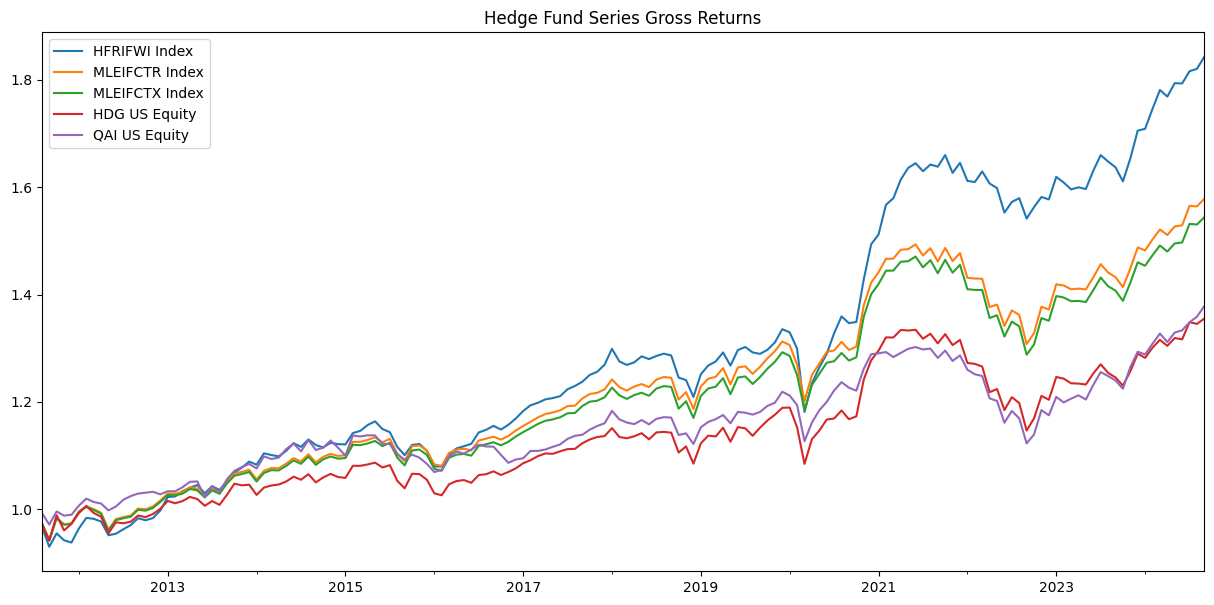

In [6]:
(data + 1).cumprod().plot(figsize=(15, 7), title='Hedge Fund Series Gross Returns')


MIN Correlation pair is ('HFRIFWI Index', 'QAI US Equity'), with a correlation of 0.8529985218248729
MAX Correlation pair is ('MLEIFCTX Index', 'MLEIFCTR Index'), with a correlation of 0.9999094742612991


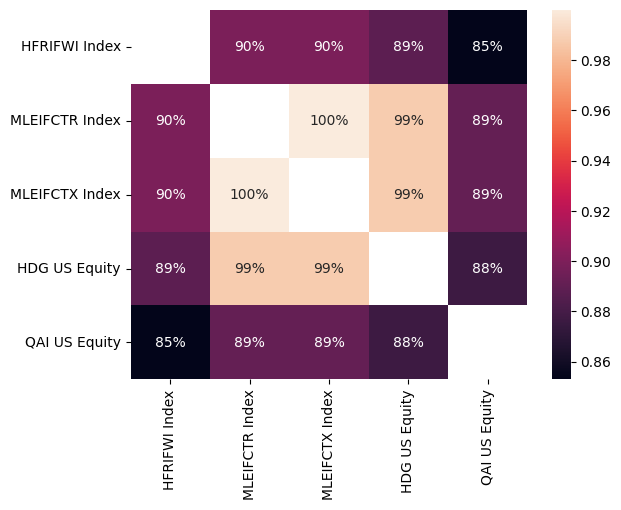

In [7]:
# correlation heatmap 

import seaborn as sns
import matplotlib.pyplot as plt

# full_df = pd.concat([spy.set_index('Date'), df], axis = 1)

def plot_corr(data: pd.DataFrame):
    corr_mtx = data.corr() 
    corr_mtx[corr_mtx==1] = None
    sns.heatmap(corr_mtx,annot=True,fmt='.0%');

    corr_rank = corr_mtx.unstack().sort_values().dropna()
    pair_max = corr_rank.index[-1]
    pair_min = corr_rank.index[0]

    min_corr_value = corr_rank.iloc[0]
    max_corr_value = corr_rank.iloc[-1]
    
    print(f'MIN Correlation pair is {pair_min}, with a correlation of {min_corr_value}')
    print(f'MAX Correlation pair is {pair_max}, with a correlation of {max_corr_value}')
    
plot_corr(data)

# Comparing Assets 

* SR, Mean, Vol
* Is it a good hedge / diversified tool?
- low corr to other assets (different baskets)
- high corr to assets within the same/similar basket

In [8]:
import numpy as np 

# returns is the main returns not annualized 
def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df

def equal_weights(returns): 
    return pd.DataFrame(index = returns.columns, data = 1/len(returns.columns), columns = ['EWP Weights'])

def gmv_weights(returns):
    ones = np.ones(returns.columns.shape)
    cov = returns.cov()* annualization_factor
    cov_inv = np.linalg.inv(cov)
    scaling = 1/(np.transpose(ones) @ cov_inv @ ones)
    gmv_tot = scaling * cov_inv @ ones
    gmv_weights_df = pd.DataFrame(gmv_tot, index=returns.columns, columns=['GMV Weights'])
    return gmv_weights_df

def risk_parity_weights(returns): 
    asset_var = returns.var().to_dict() 
    asset_inv_variance_dict = {asset: 1 / variance for asset, variance in asset_var.items()}
    rp_weights_df = pd.DataFrame.from_dict(asset_inv_variance_dict, orient='index', columns=['RP Weights'])
    return rp_weights_df



In [9]:
MU_MONTH_TARGET = 0.01 

def portfolio_returns_calc(data, weights_df): 
    return pd.DataFrame(data @ (weights_df.values)) 
    
tangency_weights_df = tangency_weights(data)
portfolio_returns = portfolio_returns_calc(data, tangency_weights_df)
portfolio_returns.columns = ['tangency_weights']
portfolio_tangency = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_tangency

,tangency_weights
2011-08-31,-0.000980
2011-09-30,0.000885
2011-10-31,-0.001871
2011-11-30,0.055620
2011-12-31,-0.024671
...,...
2024-05-31,0.014952
2024-06-30,0.016379
2024-07-31,0.030778
2024-08-31,0.004576


In [10]:
equal_weights_df = equal_weights(data)
portfolio_returns = portfolio_returns_calc(data, equal_weights_df)
portfolio_returns.columns = ['equal_weights']
portfolio_ewp = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_ewp

,equal_weights
2011-08-31,-0.082722
2011-09-30,-0.112125
2011-10-31,0.134069
2011-11-30,-0.052766
2011-12-31,0.009869
...,...
2024-05-31,0.042224
2024-06-30,0.002339
2024-07-31,0.067430
2024-08-31,0.004411


In [11]:
gmv_weights_df = gmv_weights(data)
portfolio_returns = portfolio_returns_calc(data, gmv_weights_df)
portfolio_returns.columns = ['gmv_weights']
portfolio_gmv = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_gmv

,gmv_weights
2011-08-31,-0.074687
2011-09-30,-0.243493
2011-10-31,0.186156
2011-11-30,-0.015588
2011-12-31,-0.064195
...,...
2024-05-31,0.087212
2024-06-30,0.029178
2024-07-31,0.038461
2024-08-31,0.077305


In [12]:
rp_weights_df = risk_parity_weights(data)
portfolio_returns = portfolio_returns_calc(data, rp_weights_df)
portfolio_returns.columns = ['rp_weights']
portfolio_rp = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_rp

,rp_weights
2011-08-31,-0.080218
2011-09-30,-0.111769
2011-10-31,0.134320
2011-11-30,-0.051789
2011-12-31,0.009880
...,...
2024-05-31,0.043126
2024-06-30,0.003066
2024-07-31,0.067420
2024-08-31,0.005762


In [13]:
regularized_weights_df = tangency_weights(data, scale_cov=.5, name = 'Regularized')
portfolio_returns = portfolio_returns_calc(data, regularized_weights_df)
portfolio_returns.columns = ['reg_weights']
portfolio_reg = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean() # this is scaled based on the required target
portfolio_reg

,reg_weights
2011-08-31,-0.076309
2011-09-30,-0.098030
2011-10-31,0.089533
2011-11-30,-0.029312
2011-12-31,-0.008224
...,...
2024-05-31,0.035246
2024-06-30,0.002723
2024-07-31,0.046123
2024-08-31,0.005482


In [14]:
portfolios = pd.concat([
    portfolio_tangency, 
    portfolio_ewp,
    portfolio_gmv,
    portfolio_rp,
    portfolio_reg
], axis=1)
portfolios.columns = [_.split('_')[0] for _ in portfolios.columns]
portfolio_metrics_basic(portfolios)

,Annnualized Return,Annnualized Vol,Annnualized SR
tangency,0.12,0.044550,2.693574
equal,0.12,0.191510,0.626598
gmv,0.12,0.481407,0.249270
rp,0.12,0.193256,0.620939
reg,0.12,0.155122,0.773583


In [15]:
portfolio_returns_df = pd.DataFrame(index = portfolios.columns)
    
s, k, var, cvar_s, max_dd_s, min_dates, peak_dates, recoveries, recovery_periods = zip(*[
    portfolio_metrics(portfolios[portfolio], 0.05) for portfolio in portfolios.columns
])

returns_df = pd.DataFrame(index = assets)
    
returns_df['Skewness'] = s
returns_df['Kurtosis'] = k
returns_df['var'] = var
returns_df['cvar'] = cvar_s
returns_df['peak_date'] = peak_dates
returns_df['min_date'] = min_dates
returns_df['max_dd'] = max_dd_s
returns_df['recovery'] = recoveries
returns_df['recovery'] = recovery_periods

returns_df


,Skewness,Kurtosis,var,cvar,peak_date,min_date,max_dd,recovery
HFRIFWI Index,-0.280772,2.181905,-0.011075,-0.021287,2019-12-31,2020-03-31,-0.050335,61
MLEIFCTR Index,-0.459815,2.130795,-0.088947,-0.123356,2021-06-30,2022-09-30,-0.375700,548
MLEIFCTX Index,-0.138618,0.914666,-0.206090,-0.313008,2014-08-31,2022-09-30,-0.818334,31
HDG US Equity,-0.456332,2.060355,-0.088395,-0.124706,2021-06-30,2022-09-30,-0.386109,548
QAI US Equity,-0.664766,3.323908,-0.068038,-0.097322,2019-12-31,2020-03-31,-0.268024,153


In [16]:
# scaled portfolios if no target mean is given 


wts = pd.DataFrame(index = data.columns, columns = ['tangency','equal weights',
                                                        'regularized', 'rp', 'gmv'])

wts.loc[:,'tangency'] = tangency_weights_df.values
wts.loc[:,'equal weights'] = equal_weights_df.values
wts.loc[:,'regularized'] = regularized_weights_df.values
wts.loc[:,'rp'] = rp_weights_df.values
wts.loc[:,'gmv'] = gmv_weights_df.values

wts


,tangency,equal weights,regularized,rp,gmv
HFRIFWI Index,3.507396,0.2,0.539692,3392.301551,-0.023833
MLEIFCTR Index,588.999060,0.2,0.274864,3808.073272,-11.668029
MLEIFCTX Index,-556.057728,0.2,0.222201,3829.287585,12.351039
HDG US Equity,-32.014419,0.2,-0.125514,3517.548132,-0.614202
QAI US Equity,-3.434308,0.2,0.088757,4798.240188,0.955024


In [17]:
wts_scaled = wts.copy()
wts_scaled *= (data.mean()@wts_scaled)

wts_scaled

# this is for scaled weights if the question doesnt state


,tangency,equal weights,regularized,rp,gmv
HFRIFWI Index,0.414117,0.000566,0.001929,182305.434945,-0.000024
MLEIFCTR Index,69.542905,0.000566,0.000982,204649.393291,-0.011798
MLEIFCTX Index,-65.653534,0.000566,0.000794,205789.47014,0.012489
HDG US Equity,-3.779931,0.000566,-0.000449,189036.302513,-0.000621
QAI US Equity,-0.405488,0.000566,0.000317,257861.882685,0.000966


# MV Optimization

MIN Correlation pair is ('tangency', 'gmv'), with a correlation of 0.09254230158468643
MAX Correlation pair is ('rp', 'equal'), with a correlation of 0.9997704444317737


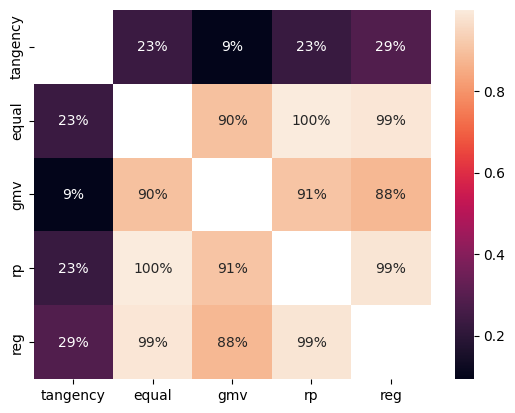

In [18]:
plot_corr(portfolios)

In [19]:
# portfolio optimization 

def mv_portfolio(target_ret, returns: pd.DataFrame):
    
    mu_tan = returns.mean() @ tangency_weights(returns,  1)
    mu_gmv = returns.mean() @ gmv_weights(returns)
    
    delta = (target_ret - mu_gmv[0])/(mu_tan[0] - mu_gmv[0])
    mv_weights = (delta * tangency_weights(returns,  1)).values + ((1-delta)*gmv_weights(returns)).values
    
    MV = pd.DataFrame(index = returns.columns, data = mv_weights, columns = ['MV Weights'] )
    MV['tangency weights'] =  tangency_weights(returns,  1).values
    MV['GMV weights'] =   gmv_weights(returns).values

    return MV


mv_portfolio(0.01, data)


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_1145/215512742.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta = (target_ret - mu_gmv[0])/(mu_tan[0] - mu_gmv[0])


,MV Weights,tangency weights,GMV weights
HFRIFWI Index,0.247328,3.507396,-0.023833
MLEIFCTR Index,34.456796,588.999060,-11.668029
MLEIFCTX Index,-31.296690,-556.057728,12.351039
HDG US Equity,-3.025404,-32.014419,-0.614202
QAI US Equity,0.617970,-3.434308,0.955024


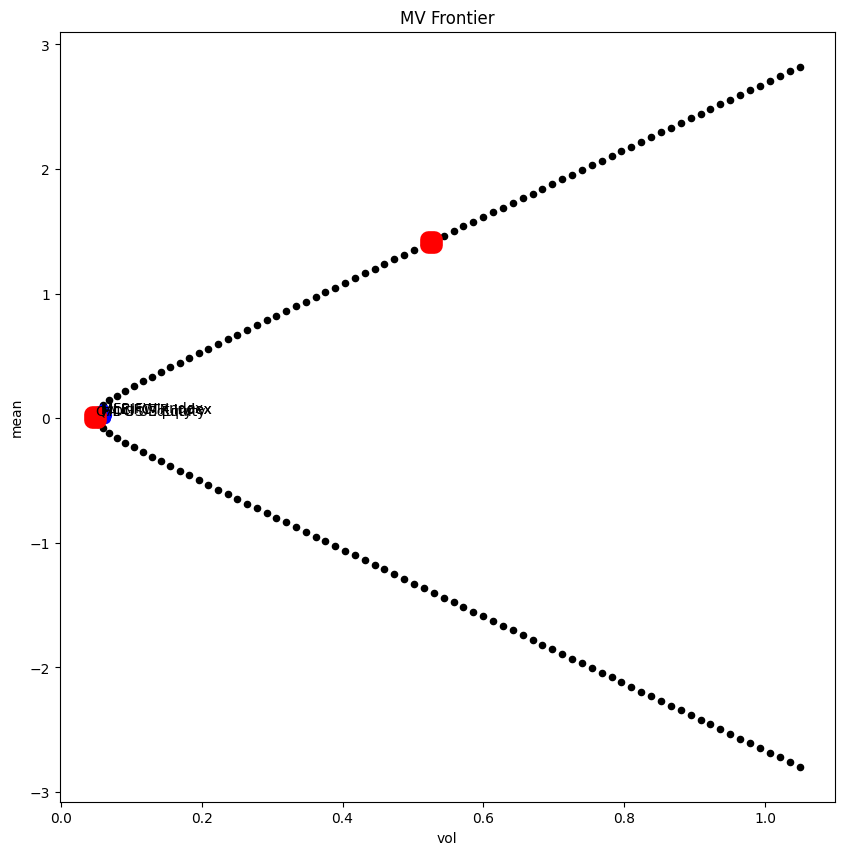

In [20]:
import warnings
warnings.filterwarnings('ignore')

# for efficient frontier plots
omega_tan = tangency_weights(data)
rets_adj = data - data.mean() + 1
omega_gmv = tangency_weights(rets_adj)
omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-2,2,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = data @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * annualization_factor
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(annualization_factor)
    
rets_special = pd.DataFrame(index=data.index)
rets_special['tan'] = data @ omega_tan.values
rets_special['gmv'] = data @ omega_gmv.values

mv_assets = pd.concat([data.mean() * annualization_factor,data.std() * np.sqrt(annualization_factor)],axis=1)
mv_special = pd.concat([rets_special.mean() * annualization_factor, rets_special.std() * np.sqrt(annualization_factor)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

# Factor Decomposition of Return Variation (Hedging vs Tracking) 


In [21]:
# Hedge ratio 
import numpy as np

def calculate_hedge_ratio(asset_returns, hedge_returns):
    # Calculate the standard deviations of both series
    sigma_asset = np.std(asset_returns)
    sigma_hedge = np.std(hedge_returns)
    
    # Calculate the correlation between the two series
    correlation = np.corrcoef(asset_returns, hedge_returns)[0, 1]
    
    # Calculate the hedge ratio
    hedge_ratio = correlation * (sigma_asset / sigma_hedge)
    
    return hedge_ratio

asset_returns = np.array([0.02, 0.03, -0.01, 0.04, 0.01])
hedge_returns = np.array([0.01, 0.02, 0.00, 0.03, 0.02])

hedge_ratio = calculate_hedge_ratio(asset_returns, hedge_returns)
print("Hedge Ratio:", hedge_ratio)

Hedge Ratio: 1.4615384615384617


## Treynor and Information Ratios

In [22]:
hf_series = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)

In [23]:
import statsmodels.api as sm

# regress against SPY to understand the HF return's sensitivity to SPY 
# Looks at treynor and information ratios

# Simple Linear Regression 

x = 'SPY US Equity'
indices = list(hf_series.columns) 

combined_data = pd.merge(hf_series, merrill_factors[x], on = merrill_factors.index)
combined_data = combined_data.set_index('key_0')
results_df = pd.DataFrame(index = indices)

def eval_performance(data, y_variable, x_variable: str):
    y = data[y_variable]
    x = sm.add_constant(data[x_variable])
    
    model = sm.OLS(y, x).fit()
    r_squared = model.rsquared
    
    # Betas need not be annualized 
    beta = model.params[x_variable] # beta term (can be seen as the optimal hedge ratio) 
    alpha = model.params['const'] # alpha term
    annualized_alpha = alpha * 52
    residuals = model.resid 
    std_error = np.std(residuals, ddof=1)

    # Annualized ratios. 
    treynor_ratio = (y.mean() * annualization_factor)/beta # amount of returns from asset per unit of risk (beta) taken == systematic risk
    information_ratio = (alpha/std_error)  * np.sqrt(annualization_factor) # sharpe ratio of the non factor component of the return == active risk 
    # since its tracking error where it highlights the risk taken by deviating from the benchmark 

    annualized_return = data.mean() * annualization_factor 
    sortino_ratio = annualized_return / (data[data<0].std() * np.sqrt(annualization_factor))
    
    return beta, treynor_ratio, information_ratio, alpha, r_squared

# summary['Sortino Ratio'] = summary['Fitted Mean'] / y[y < 0].std()    # 
# summary['Annualized Sortino Ratio'] = summary['Sortino Ratio'] * np.sqrt(annual_factor)


for factor in indices: 
    
    outcomes = eval_performance(combined_data, factor, x)
    
    # Annualized 
    results_df.loc[factor, 'Alpha'] = outcomes[3] 
    results_df.loc[factor, 'Market Beta'] = outcomes[0]
    results_df.loc[factor, 'Treynor Ratio'] = outcomes[1]
    results_df.loc[factor, 'Information Ratio'] = outcomes[2] 
    results_df.loc[factor, 'R Square'] = outcomes[4] 
    
    
results_df
    


,Alpha,Market Beta,Treynor Ratio,Information Ratio,R Square
HFRIFWI Index,-0.000095,0.346131,0.139528,-0.035836,0.711480
MLEIFCTR Index,-0.001063,0.343383,0.105672,-0.491479,0.786051
MLEIFCTX Index,-0.001189,0.342171,0.101134,-0.549547,0.784862
HDG US Equity,-0.002123,0.352053,0.070478,-0.896268,0.763208
QAI US Equity,-0.001414,0.298376,0.085976,-0.675558,0.747822


When to include alpha? 

- in the case of indices, its not necessary to include alpha to determine the composition since the index is mainly interested in their exposure to systematic risk factors which should ideally be fully explained by this linear combination.
- it should not be concerned about excess returns / alpha which is not explained fully
- but sometimes, alpha is used to de-mean the data so beta will just focus on decreasing standard devition around the data since alpha acts as a leveller to improve good fit for the betas around the dataset.


Recall: Factors affecting beta of the factors 
- correlation, number of regressors, amount of data points

eg. HF has 20% returns, alpha = 0. 
- this means the HF has leveraged beta (eg. beta = 2, * 10 leverage)
- regress against the market returns and test if its explained by the market
- types of HF: alpha capture, B trading (rolling regressions -> were they just overweight on things that did well) 

eg. In the concept of hedging, optimal hedge ratio can be interpreted as the Beta for a simple linear regression 
- if beta = 0.2, to hedge, just short 20% of the asset on the portfolio. 
- As such, once the portfolio is hedged, just look at the remaining terms == alpha + error term 
- therefore, we end up looking at the error term which can be interprete d from the r**2 where high r**2 = small error, and this helps us to understand how hedged the portfolio is.


Interpretation of ratios and intercept terms: 

The alphas are negative which suggest that these indices did not provide any outperformance and they all underperformed SPY. Nonetheless, as their betas are positive, they have some positive influence on the SPY. However, when we include the standard errors and obtain the information ratios, they indicate a strong underperformance. Information ratio refers to the tradeoff between obtaining an extra mean return from alpha at the cost of a taking on the tracking error from the portfolio. In this case, since the IR is negative, there is a strong underperformance of the hedge funds.



QAI performs better since it has a lower beta (from the risk) and higher Treynor ratio = higher expected return per unit of market risk taken and a higher information ratio relative to the benchmark of the SPY.

## Replication Model

In [24]:
merrill_factors.head()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,-0.054976,0.000009,-0.092549,-0.087549,-0.005889,-0.088913
2011-09-30,-0.069420,0.000017,-0.179063,-0.108082,0.142180,-0.111505
2011-10-31,0.109147,-0.000013,0.162986,0.096274,-0.069502,0.151011
2011-11-30,-0.004064,0.000000,-0.019724,-0.021765,0.054627,-0.003784
2011-12-31,0.010449,0.000009,-0.042649,-0.021744,0.075581,0.005144


In [25]:
import statsmodels.api as sm


factors = list(merrill_factors.columns)
results_df = pd.DataFrame(index = list(factors), columns = ['Market Beta', 'Treynor Ratio', 'Information Ratio'])

# Multi Linear Regression model for replication to understand the tracking error

y_factor = 'HFRIFWI Index'
data = pd.merge(merrill_factors, hf_series[y_factor], on = hf_series.index) 


def get_params(data, y_col: str, x_col: list):
    columns = ['Alpha', 'R-Squared'] + x_col + ['Tracking Error']
    params_df = pd.DataFrame(index=columns)
    
    y = data[y_col]
    x = data[x_col]
    model = sm.OLS(y, x).fit()
    r_squared = model.rsquared
    betas = model.params
    p_values = model.pvalues

    
    tracking_error = (model.resid).std()*np.sqrt(annualization_factor) # tracking error represents the index tracking error to the actual underlying 
    # can be increased due to massive redemptions and creation processes which dislocate the prices 
    
    parameters = [0] + [r_squared] + list(betas) + [tracking_error]
    params_df['Without Intercept'] = parameters
    
    x = sm.add_constant(x)
    model_alpha = sm.OLS(y, x).fit()
    r_squared_model_alpha = model_alpha.rsquared
    betas_model_alpha = model_alpha.params[1:]
    alpha_model_alpha = model_alpha.params[0]
    p_values_model_alpha = model_alpha.pvalues
    
    tracking_error_alpha = (model_alpha.resid).std()*np.sqrt(annualization_factor)
    
    parameters = [alpha_model_alpha] + [r_squared_model_alpha] + list(betas_model_alpha) + [tracking_error_alpha]
    params_df['With Intercept'] = parameters

    return params_df 


# summary['Sortino Ratio'] = summary['Fitted Mean'] / y[y < 0].std()    # 
# summary['Annualized Sortino Ratio'] = summary['Sortino Ratio'] * np.sqrt(annual_factor)


get_params(data, y_factor, factors)




,Without Intercept,With Intercept
Alpha,0.000000,0.001235
R-Squared,0.845162,0.839676
SPY US Equity,0.050667,0.036483
USGG3M Index,0.499336,0.146336
EEM US Equity,0.080866,0.081611
EFA US Equity,0.079146,0.084638
EUO US Equity,0.031373,0.028806
IWM US Equity,0.142651,0.145111
Tracking Error,0.023908,0.023815


### Index Replication

In [26]:
hf_series = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)

##### Rolling Regression

<Axes: >

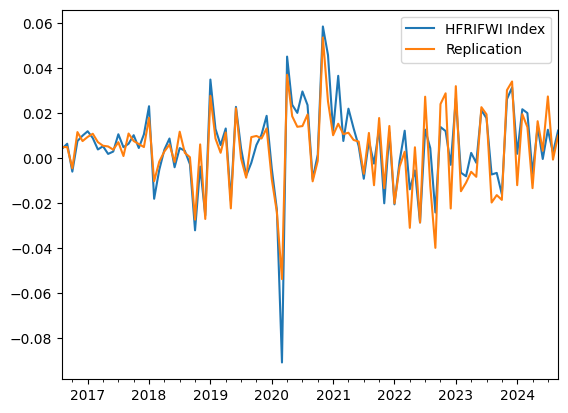

In [27]:
# Using the past n months as the in sample data 
# then start from n + 1 for out of sample data 

# method 1

n = 60 
length = len(hf_series['HFRIFWI Index'])

data = hf_series[['HFRIFWI Index']].copy()
data['Replication'] = np.nan

for i in range(n, length):
    
    y = hf_series['HFRIFWI Index'].iloc[i - 60:i]
    x = sm.add_constant(merrill_factors).iloc[i - 60:i]
    
    m = sm.OLS(y,x).fit()
    
    oos_val = sm.add_constant(merrill_factors).iloc[i].to_numpy().reshape((7))

    rep_val = m.predict(oos_val)
    
    data['Replication'].iloc[i] = rep_val

data.dropna().plot()

The OOS R-Squared of the replication is 0.7994


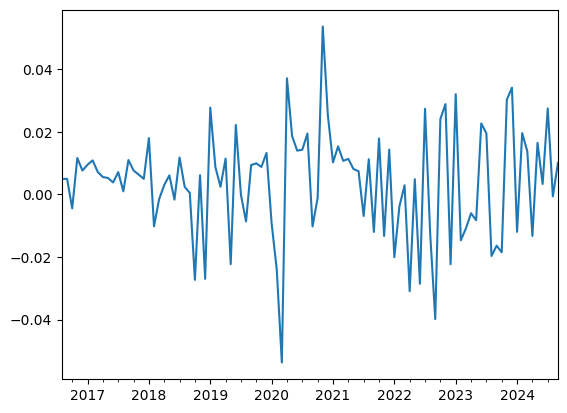

In [28]:
# method 2


x = sm.add_constant(merrill_factors)
y = hf_series['HFRIFWI Index']

from statsmodels.regression.rolling import RollingOLS
rolling = RollingOLS(y,x,window=60).fit()
rolling_betas = rolling.params
replication_rolling = (rolling_betas.shift() * x).dropna().sum(axis=1)
replication_rolling.plot()
oos_loss = (data.dropna().diff(axis=1)**2)['Replication'].sum()
oos_mean = data.dropna()['HFRIFWI Index'].mean()
oos_loss_null = ((data.dropna()['HFRIFWI Index'] - oos_mean)**2).sum()

oos_r2 = 1 - oos_loss / oos_loss_null

print(f'The OOS R-Squared of the replication is {round(oos_r2,4)}')

# interpreting Betas for hedging

- If long = 100M on a stock, hedge with the betas of other stocks. their betas will then be multiplied by -100M to gdetermine their exposures.
- Look at R square to understand how much of the variance of the stock is hedged. Check the annual tracking error where there can be large variations as well.
- if the amount hedged > initial amount position -> not practical 